In [96]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import holidays
import seaborn as sns
from plotly.subplots import make_subplots

In [97]:
# Load main data
file_path = "../data/ChallengeXHEC23022024.xlsx"


excel_data = pd.ExcelFile(file_path)


jan24_df = pd.read_excel(excel_data, sheet_name="JAN24")
clients_df = pd.read_excel(excel_data, sheet_name="clients")
intervenants_df = pd.read_excel(excel_data, sheet_name="intervenants")

In [98]:
# Loading and merging commute data
commute_file_paths = [
    '../data/commute_bicycling_clients.csv',
    '../data/commute_driving_clients.csv',
    '../data/commute_bicycling_care_clients.csv',
    '../data/commute_bicycling_clients_care.csv',
    '../data/commute_driving_care_clients.csv',
    '../data/commute_driving_clients_care.csv'
]


commute_dataframes = [pd.read_csv(file) for file in commute_file_paths]


for df in commute_dataframes:
    if df.columns[0] not in ['pair']: #standardizing column names
        df.rename(columns={df.columns[0]: 'pair'}, inplace=True)

commute_data_df = pd.concat(commute_dataframes, ignore_index=True)

In [99]:
commute_data_df

,pair,commute_seconds,commute_meters,source,destination,commute_method
0,"(559475456, 559475456)",0,0,559475456,559475456,bicycling
1,"(559475456, 559277088)",0,0,559475456,559277088,bicycling
2,"(559475456, 87852633)",2655,12103,559475456,87852633,bicycling
3,"(559475456, 243033408)",1092,4215,559475456,243033408,bicycling
4,"(559475456, 814940942)",426,2015,559475456,814940942,bicycling
...,...,...,...,...,...,...
39171,"(334442311, 776399834)",856,10016,334442311,776399834,driving
39172,"(621952854, 776399834)",386,2775,621952854,776399834,driving
39173,"(1452858131, 776399834)",763,7634,1452858131,776399834,driving
39174,"(846949801, 776399834)",560,3597,846949801,776399834,driving


In [100]:
jan24_df

,ID Client,ID Intervenant,Date,Heure de début,Heure de fin,Prestation
0,559475456,162858075,2024-01-01,07:15:00,07:45:00,REPAS
1,559277088,162858075,2024-01-01,07:45:00,08:30:00,TOILETTE
2,87852633,78007018,2024-01-01,07:45:00,08:30:00,TOILETTE
3,243033408,810259688,2024-01-01,07:45:00,08:15:00,TOILETTE
4,814940942,710283561,2024-01-01,07:45:00,09:20:00,TOILETTE
...,...,...,...,...,...,...
2865,559277088,710283561,2024-01-31,19:00:00,19:15:00,REPAS
2866,714782168,810259688,2024-01-31,19:00:00,20:00:00,REPAS
2867,559475456,710283561,2024-01-31,19:15:00,20:00:00,TOILETTE
2868,803656603,854577575,2024-01-31,19:20:00,19:50:00,TOILETTE


In [101]:
clients_df

,ID Client,Latitude,Longitude
0,559475456,48.721052,1.375689
1,559277088,48.721052,1.375689
2,87852633,48.691944,1.498773
3,243033408,48.726393,1.332848
4,814940942,48.733174,1.370689
...,...,...,...
113,334442311,48.771381,1.292168
114,621952854,48.742805,1.351704
115,1452858131,48.776801,1.370417
116,846949801,48.733484,1.371047


In [102]:
intervenants_df

,ID Intervenant,Latitude,Longitude,Compétences,Permis,Véhicule personnel,Dispo / Indispo
0,838320706,48.738516,1.391971,"AIDE MENAGERE, REPAS, TOILETTE",Oui,Oui,"Indispo 01/01, 30/01, 31/01"
1,609468992,48.640555,1.232581,"TOILETTE, REPAS, VIE SOCIALE, AIDE MENAGERE",Oui,Oui,"Indispo Tous les mercredis + 13/01, 14/01, 27/..."
2,78012267,48.729206,1.371985,"HOMMES TOUTES MAINS, JARDINAGE",Oui,Oui,Dispo le 25/01
3,818696864,48.744702,1.357921,"REPAS, AIDE MENAGERE, ACCOMPAGNEMENTS COURSES,...",Oui,Oui,Indispo tous les samedis et dimanche
4,746414886,48.769455,1.197644,"TOILETTE, REPAS, AIDE MENAGERE, ACCOMPAGNEMENT...",Oui,Oui,Indispo tous les mercredis + le 05/01
5,78005437,48.712418,1.356278,"AIDE MENAGERE, ADMINISTRATION, REPAS, TOILETTE...",Oui,Oui,Indispo tous les samedis et dimanche
6,213237245,48.763226,1.241120,"TOILETTE, REPAS, AIDE MENAGERE",Oui,Oui,"Indispo 01/01, 02/01, 03/01, 13/01, 14/01, 16/..."
7,813991780,48.692715,1.073195,"TOILETTE, REPAS, AIDE MENAGERE, ACCOMPAGNEMENT...",Oui,Oui,"Indispo tous les mercredis, vendredi, samedi, ..."
8,856089133,48.645418,1.523077,"ACCOMPAGNEMENTS COURSES PA, REPAS, TOILETTE, A...",Non,Non,"Indispo 05/01, 09/01, 11/01 + du 18/01 au 31/0..."
9,700168298,48.758099,1.210611,"TOILETTE, REPAS, AIDE MENAGERE, ACCOMPAGNEMENT...",Oui,Oui,"Dispo le 01/01, 30/01 et 31/01"


In [103]:
# Analyze start/end times for each type of service
jan24_df["Heure de début"] = pd.to_datetime(
    jan24_df["Heure de début"], format="%H:%M:%S"
).dt.time
jan24_df["Heure de fin"] = pd.to_datetime(
    jan24_df["Heure de fin"], format="%H:%M:%S"
).dt.time
service_constraints = jan24_df.groupby("Prestation").agg(
    {"Heure de début": ["min", "max"], "Heure de fin": ["min", "max"]}
)
service_constraints.columns = [
    "Start Time Earliest",
    "Start Time Latest",
    "End Time Earliest",
    "End Time Latest",
]
service_constraints.reset_index(inplace=True)


print(service_constraints)

                    Prestation Start Time Earliest Start Time Latest  \
0   ACCOMPAGNEMENTS COURSES PA            08:45:00          17:30:00   
1               ADMINISTRATION            07:30:00          14:30:00   
2                AIDE MENAGERE            08:00:00          18:15:00   
3                 COORDINATION            08:30:00          17:40:00   
4              FEMME DE MENAGE            09:00:00          09:00:00   
5                    FORMATION            08:30:00          19:30:00   
6              GARDE D'ENFANTS            12:00:00          18:20:00   
7          HOMMES TOUTES MAINS            10:00:00          13:00:00   
8                        REPAS            07:00:00          19:45:00   
9                     TOILETTE            07:00:00          20:55:00   
10                 VIE SOCIALE            09:00:00          17:40:00   
11             VISITE MEDICALE            10:20:00          10:20:00   

   End Time Earliest End Time Latest  
0           10:00:00    

In [104]:
prestation_segmented_data = {prestation: group for prestation, group in jan24_df.groupby('Prestation')}


toilette_data = prestation_segmented_data['TOILETTE']  # Replace 'TOILETTE' with the desired service segmented data


In [105]:
# Segment clients according to their needs
client_needs = (
    jan24_df.groupby(["ID Client", "Prestation"]).size().unstack(fill_value=0)
)

print(client_needs)

Prestation  ACCOMPAGNEMENTS COURSES PA  ADMINISTRATION  AIDE MENAGERE  \
ID Client                                                               
78690893                             0               0             28   
78691334                             4               0             13   
78691389                             0               0              5   
78691461                             0               0              4   
78692265                             2               0              5   
...                                ...             ...            ...   
1452740690                           1               0              0   
1452763176                           0               0              3   
1452775101                           0               0              0   
1452858131                           0               0              0   
1453084257                           0               0              2   

Prestation  COORDINATION  FEMME DE MENAGE  FORMATI

In [106]:
# Segment days according to the services offered
jan24_df["Day of Week"] = jan24_df["Date"].dt.dayofweek
jan24_df["Day Type"] = jan24_df["Day of Week"].apply(
    lambda x: "Weekend" if x > 4 else "Weekday"
)
day_segmentation = (
    jan24_df.groupby(["Day Type", "Prestation"]).size().unstack(fill_value=0)
)

day_segmentation.T

Day Type,Weekday,Weekend
Prestation,,
ACCOMPAGNEMENTS COURSES PA,83,0
ADMINISTRATION,79,0
AIDE MENAGERE,435,8
COORDINATION,10,0
FEMME DE MENAGE,4,0
FORMATION,15,0
GARDE D'ENFANTS,10,0
HOMMES TOUTES MAINS,2,0
REPAS,696,214


In [107]:
day_seg_inv = day_segmentation.T
print(
    "Weekday services: ", day_seg_inv[day_seg_inv.Weekday > 0].index.to_list()
)
print(
    "Weekend services: ", day_seg_inv[day_seg_inv.Weekend > 0].index.to_list()
)

Weekday services:  ['ACCOMPAGNEMENTS COURSES PA', 'ADMINISTRATION', 'AIDE MENAGERE', 'COORDINATION', 'FEMME DE MENAGE', 'FORMATION', "GARDE D'ENFANTS", 'HOMMES TOUTES MAINS', 'REPAS', 'TOILETTE', 'VIE SOCIALE', 'VISITE MEDICALE']
Weekend services:  ['AIDE MENAGERE', 'REPAS', 'TOILETTE', 'VIE SOCIALE']


In [108]:
services_per_day = jan24_df.groupby('Date').size()

fig = go.Figure()
fig.add_trace(go.Scatter(x=services_per_day.index, y=services_per_day.values, mode='lines+markers', marker_color='blue'))
fig.update_layout(title='Total Number of Services Provided Per Day', xaxis_title='Date', yaxis_title='Number of Services', xaxis_tickangle=-45)
fig.show()


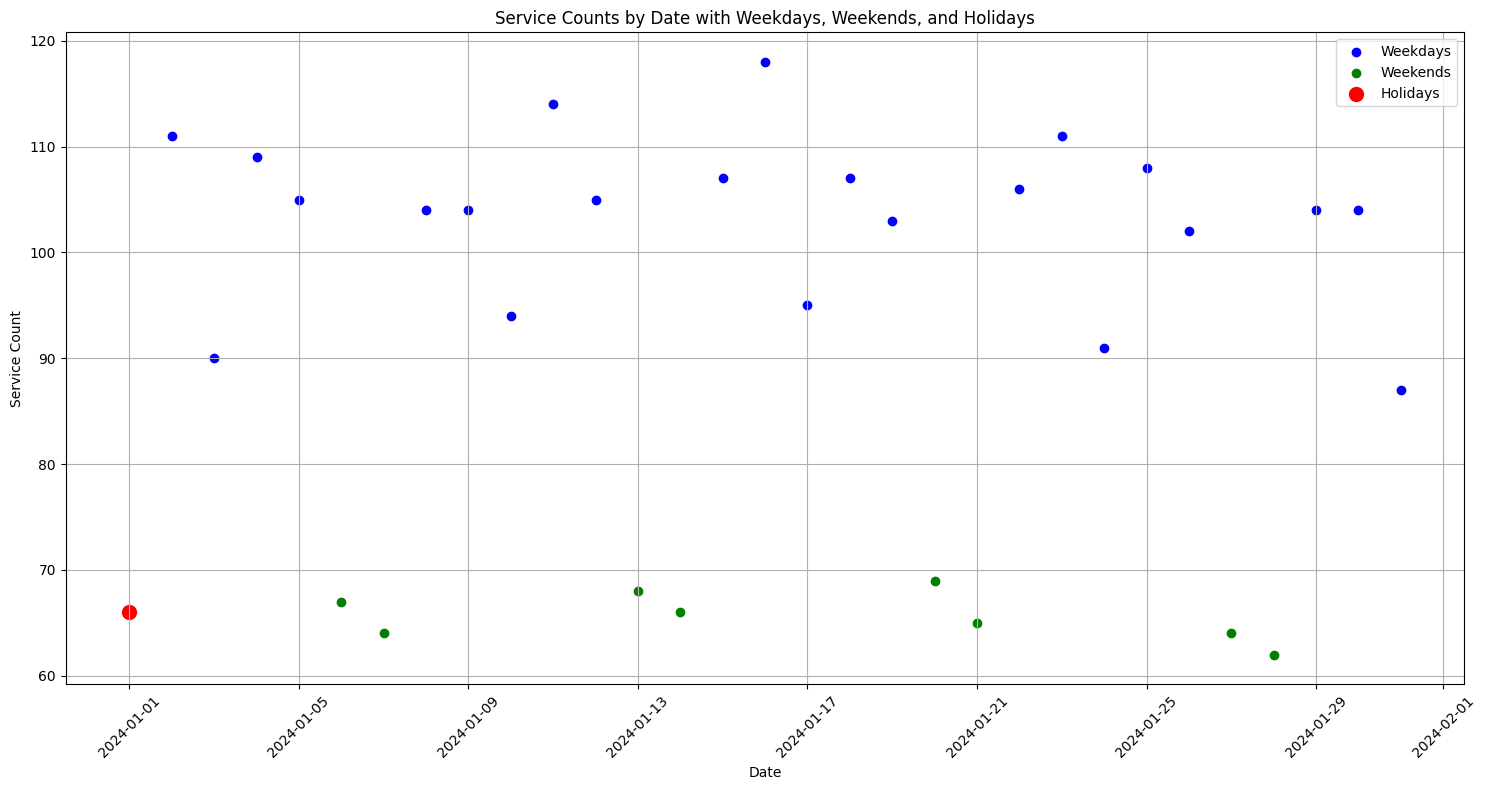

In [109]:
# Extracting weekdays and weekends
jan24_df['Day Type'] = np.where(jan24_df['Date'].dt.dayofweek < 5, 'Weekday', 'Weekend')

fr_holidays = holidays.France(years=2024) # extracting French holidays
jan24_df['Holiday'] = jan24_df['Date'].apply(lambda x: fr_holidays.get(x))

# Counting services per day and categorizing them
daily_services = jan24_df.groupby(['Date', 'Day Type']).size().reset_index(name='Service Count')
daily_services['Holiday'] = daily_services['Date'].apply(lambda x: fr_holidays.get(x) is not None)

# Plotting
plt.figure(figsize=(15, 8))
weekday_services = daily_services[daily_services['Day Type'] == 'Weekday']
plt.scatter(weekday_services['Date'], weekday_services['Service Count'], color='blue', label='Weekdays')
weekend_services = daily_services[daily_services['Day Type'] == 'Weekend']
plt.scatter(weekend_services['Date'], weekend_services['Service Count'], color='green', label='Weekends')
holiday_services = daily_services[daily_services['Holiday']]
plt.scatter(holiday_services['Date'], holiday_services['Service Count'], color='red', label='Holidays', s=100)
plt.title('Service Counts by Date with Weekdays, Weekends, and Holidays')
plt.xlabel('Date')
plt.ylabel('Service Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [110]:
# Frequency of each service type by day of week
jan24_df['Day of Week'] = jan24_df['Date'].dt.day_name()
service_by_day = jan24_df.groupby(['Prestation', 'Day of Week']).size().unstack(fill_value=0)

fig = px.bar(service_by_day, barmode='group', labels={'value': 'Frequency', 'variable': 'Day of Week'}, title='Service Frequency by Day of the Week')
fig.show()

# Analyzing service corelation
service_combinations = jan24_df.pivot_table(index=['Date', 'ID Client'], columns='Prestation', aggfunc='size', fill_value=0)
service_correlation = service_combinations.corr()

fig = px.imshow(service_correlation, x=service_correlation.index, y=service_correlation.columns)
fig.update_layout(title='Service Correlation Heatmap')
fig.update_layout(height=600, width=800)  
fig.show()


In [111]:
# Average Duration of Each Service
jan24_df['Service Duration'] = (pd.to_datetime(jan24_df['Heure de fin'], format='%H:%M:%S') - 
                                pd.to_datetime(jan24_df['Heure de début'], format='%H:%M:%S')).dt.total_seconds() / 3600
average_duration = jan24_df.groupby('Prestation')['Service Duration'].mean()

fig = px.bar(average_duration, labels={'value': 'Average Duration (hours)', 'variable': 'Service'}, title='Average Duration of Each Service')
fig.show()


In [112]:

# Client-Caretaker Pairing Patterns
client_caretaker_pairing = jan24_df.groupby(['ID Client', 'ID Intervenant']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)

print(client_caretaker_pairing.sort_values(by='Count', ascending=False))

      ID Client  ID Intervenant  Count
414   794098228       213237245     49
252   552306887       609468992     43
85     99999999        78005437     41
151   446362468       764144581     41
86     99999999        78007018     38
..          ...             ...    ...
453   833548586       854577575      1
454   846949801        78005437      1
455   855391156       888888888      1
456   858147751        78005437      1
500  1453084257       710283561      1

[501 rows x 3 columns]


In [113]:

#Peak Service Hours Analysis
jan24_df['Hour of Day'] = pd.to_datetime(jan24_df['Heure de début'], format='%H:%M:%S').dt.hour
peak_hours = jan24_df.groupby('Hour of Day').size()
fig = px.bar(peak_hours, labels={'value': 'Frequency', 'variable': 'Hour of Day'}, title='Peak Service Hours Analysis')
fig.show()


In [114]:

# Grouping data by caretaker and date to count the number of services provided each day
caretaker_daily_workload = jan24_df.groupby(['ID Intervenant', jan24_df['Date'].dt.date]).size()
caretaker_daily_workload = caretaker_daily_workload.reset_index(name='Daily Service Count')

# Grouping data by caretaker and week to count the number of services provided each week
jan24_df['Week'] = jan24_df['Date'].dt.isocalendar().week
caretaker_weekly_workload = jan24_df.groupby(['ID Intervenant', 'Week']).size()
caretaker_weekly_workload = caretaker_weekly_workload.reset_index(name='Weekly Service Count')

In [115]:
def plot_daily_workload(caretaker_daily_workload, caretaker_id):
    sample_caretaker = caretaker_daily_workload[caretaker_daily_workload['ID Intervenant'] == caretaker_id]
    fig = px.bar(sample_caretaker, x='Date', y='Daily Service Count', title=f'Daily Workload for Caretaker {caretaker_id}')
    fig.update_layout(xaxis_title='Date', yaxis_title='Number of Services')
    fig.show()

plot_daily_workload(caretaker_daily_workload, 78005437)


In [116]:
def plot_weekly_workload(caretaker_weekly_workload, caretaker_id):
    sample_caretaker_weekly = caretaker_weekly_workload[caretaker_weekly_workload['ID Intervenant'] == caretaker_id]
    fig = px.line(sample_caretaker_weekly, x='Week', y='Weekly Service Count', title=f'Weekly Workload for Caretaker {caretaker_id}', markers=True)
    fig.update_layout(xaxis_title='Week', yaxis_title='Number of Services')
    fig.show()

plot_weekly_workload(caretaker_weekly_workload, 78005437)


# Plotting agenda and commute time calcualtion 

In [117]:
intervenants_df['Commute Method'] = intervenants_df['Véhicule personnel'].map({'Oui': 'driving', 'Non': 'bicycling', np.nan: 'bicycling'}) #map commute method
jan24_df = jan24_df.merge(intervenants_df[['ID Intervenant', 'Commute Method']], on='ID Intervenant', how='left') # merge with agenda data

jan24_df["Start DateTime"] = pd.to_datetime(
    jan24_df["Date"].astype(str) + " " + jan24_df["Heure de début"].astype(str)
)
jan24_df["End DateTime"] = pd.to_datetime(
    jan24_df["Date"].astype(str) + " " + jan24_df["Heure de fin"].astype(str)
)

commute_data_df[['source', 'destination']] = commute_data_df['pair'].str.extract(r'\((\d+), (\d+)\)')
commute_data_df.drop(columns='pair', inplace=True)
commute_data_df.set_index(['source', 'destination', 'commute_method'], inplace=True)


In [118]:
def compute_commute_and_wait_times(df, commute_data_df):
    df['Wait Time'] = 0
    df['Commute Time'] = 0

    for intervenant_id in df['ID Intervenant'].unique():
        intervenant_data = df[df['ID Intervenant'] == intervenant_id]

        for date in intervenant_data['Date'].unique():
            daily_data = intervenant_data[intervenant_data['Date'] == date].sort_values(by='Start DateTime')
            prev_end_time = None
            prev_client_id = None  

            for index, row in daily_data.iterrows():
                if prev_client_id is None or prev_end_time is None:
                    source_id = str(intervenant_id)
                else:
                
                    wait_time = (row['Start DateTime'] - prev_end_time).total_seconds()
                    df.loc[index, 'Wait Time'] = wait_time

                    # Check if wait time is greater than 1 hour (3600 seconds)
                    if wait_time > 3600:
                        source_id = str(intervenant_id)
                    else:
                        source_id = str(prev_client_id)

                destination_id = str(row['ID Client'])
                commute_method = row['Commute Method'] if 'Commute Method' in row else 'driving'

                try:
                    commute_time = commute_data_df.loc[(source_id, destination_id, commute_method), 'commute_seconds']
                except KeyError:
                    commute_time = 0  # Default to 0 if not found
                    print(f'Data not found for commute time: {source_id}, {destination_id}, {commute_method}')

                
                df.loc[index, 'Commute Time'] = commute_time

                # Update previous end time and client ID for next iteration
                prev_end_time = row['End DateTime']
                prev_client_id = row['ID Client']

    return df



In [119]:
def plot_agenda_for_intervenant(intervenant_id, jan24_df, commute_data_df):
    intervenant_agenda = jan24_df[jan24_df["ID Intervenant"] == intervenant_id]
    intervenant_agenda_sorted = intervenant_agenda.sort_values(by=["Date", "Heure de début"])

    df_timeline = intervenant_agenda_sorted.copy()
    df_timeline["Start"] = pd.to_datetime(df_timeline["Start DateTime"])
    df_timeline["Finish"] = pd.to_datetime(df_timeline["End DateTime"])
    df_timeline["Task"] = df_timeline["Prestation"]
    df_timeline["Resource"] = df_timeline["ID Intervenant"].astype(str)
    df_timeline["ID Client"] = df_timeline["ID Client"].astype(str)

    # Compute wait and commute times
    df_timeline = compute_commute_and_wait_times(df_timeline, commute_data_df)

    fig = px.timeline(
        df_timeline,
        x_start="Start",
        x_end="Finish",
        y="Task",
        hover_data=["ID Client", "Wait Time"],
        color= 'Commute Time'

    )
    fig.update_yaxes(autorange="reversed")
    fig.update_layout(title=f"Agenda for Intervenant ID: {intervenant_id}")
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list(
                    [
                        dict(count=1, label="1D", step="day", stepmode="backward"),
                        dict(count=7, label="1W", step="day", stepmode="backward"),
                        dict(step="all"),
                    ]
                )
            ),
            rangeslider=dict(visible=True),
            type="date",
        )
    )

    fig.show()

    return df_timeline



In [120]:
all_intervenant_agendas = []
for intervenant_id in jan24_df["ID Intervenant"].unique():
    intervenant_agenda = plot_agenda_for_intervenant(intervenant_id, jan24_df, commute_data_df)
    all_intervenant_agendas.append(intervenant_agenda)


# Commute time stats

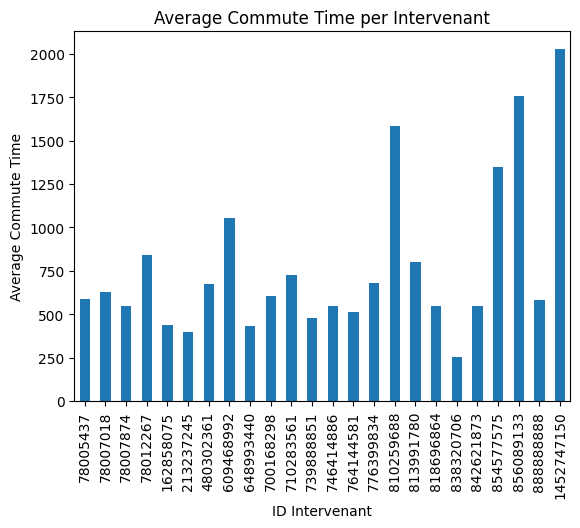

In [121]:
df_agendas = pd.concat(all_intervenant_agendas) 

# Avergae commute time
average_commute_time = df_agendas.groupby("ID Intervenant")["Commute Time"].mean()
average_commute_time.plot(kind='bar')
plt.xlabel("ID Intervenant")
plt.ylabel("Average Commute Time")
plt.title("Average Commute Time per Intervenant")
plt.show()


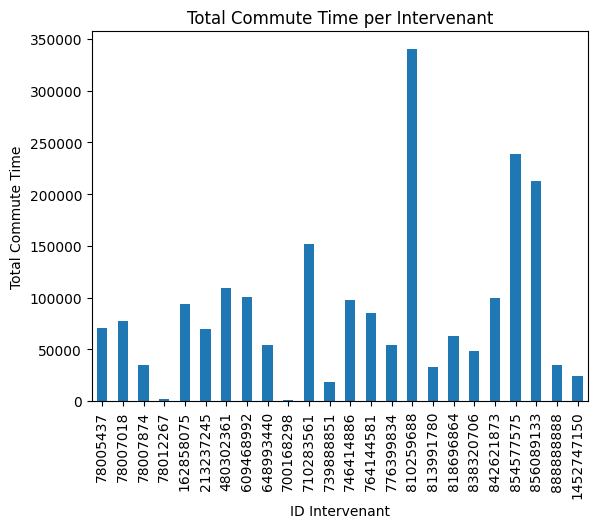

In [122]:
# Total commute time

total_commute_time = df_agendas.groupby('ID Intervenant')['Commute Time'].sum()

total_commute_time.plot(kind='bar')
plt.xlabel("ID Intervenant")
plt.ylabel("Total Commute Time")
plt.title("Total Commute Time per Intervenant")
plt.show()

In [123]:
# Distribution of commit times 
fig = px.histogram(df_agendas, x='Commute Time', nbins=20, 
                   labels={'Commute Time': 'Commute Time (seconds)', 'count': 'Frequency'},
                   title='Distribution of Commute Times')
fig.show()


In [124]:
# Commute Time vs. Number of Appointments
appointments_per_caretaker = df_agendas.groupby('ID Intervenant').size().reset_index()
appointments_per_caretaker.columns = ['ID Intervenant', 'Number of Appointments']

commute_vs_appointments = pd.merge(total_commute_time, appointments_per_caretaker, on='ID Intervenant')


fig = px.scatter(commute_vs_appointments, x='Number of Appointments', y='Commute Time', 
                 labels={'Number of Appointments': 'Number of Appointments', 'Commute Time': 'Total Commute Time (seconds)'},
                 title='Total Commute Time vs. Number of Appointments')
fig.show()

In [125]:
# Average commute time 
if 'Commute Method' in df_agendas.columns:
    commute_time_by_method = df_agendas.groupby('Commute Method')['Commute Time'].mean().reset_index()
    
    fig = px.bar(commute_time_by_method, x='Commute Method', y='Commute Time', 
                 labels={'Commute Method': 'Commute Method', 'Commute Time': 'Average Commute Time (seconds)'},
                 title='Average Commute Time by Commute Method')
    fig.show()
else:
    print("The 'Commute Method' column is not available in the dataframe.")